## Imports & Config

In [1]:
import torch
import torch.nn as nn 
import yaml
from arcade_dataset import load_dataset, ArcadeDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config = yaml.load(open('model_overfit_config.yaml', 'r'), Loader=yaml.FullLoader)

In [4]:
modalities, H_in, W_in = config['input']['image_shape']

## Model Definition

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, gn_groups=8):
        super(ResBlock, self).__init__()
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.block = nn.Sequential(
            nn.GroupNorm(gn_groups, in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(gn_groups, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
    def forward(self, x):
        res = self.residual(x)
        x = self.block(x)
        x = x + res
        return x

In [6]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_shape=(1, H_in, W_in), gn_groups=8, n_init_features=32):
        super(UNetEncoder, self).__init__()
        H_in, W_in = out_shape[1], out_shape[2]
        self.initial_conv = nn.Conv2d(in_channels, n_init_features, kernel_size=3, stride=1, padding=1)
        self.blocks = nn.ModuleList([
            ResBlock(n_init_features * 1, n_init_features * 1, gn_groups),
            nn.Sequential(
                ResBlock(n_init_features * 1, n_init_features * 2, gn_groups),
                ResBlock(n_init_features * 2, n_init_features * 2, gn_groups)
            ),
            nn.Sequential(
                ResBlock(n_init_features * 2, n_init_features * 4, gn_groups),
                ResBlock(n_init_features * 4, n_init_features * 4, gn_groups)
            ),
            nn.Sequential(
                ResBlock(n_init_features * 4, n_init_features * 8, gn_groups),
                ResBlock(n_init_features * 8, n_init_features * 8, gn_groups),
                ResBlock(n_init_features * 8, n_init_features * 8, gn_groups),
                ResBlock(n_init_features * 8, n_init_features * 8, gn_groups)
            )])
        self.downsamples = nn.ModuleList([
            nn.AdaptiveMaxPool2d((H_in // 2, W_in // 2)),
            nn.AdaptiveMaxPool2d((H_in // 4, W_in // 4)),
            nn.AdaptiveMaxPool2d((H_in // 8, W_in // 8))
        ])
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = nn.Dropout2d(0.2)(x)
        x = self.blocks[0](x)
        skips = []
        for block, downsample in zip(self.blocks[1:], self.downsamples):
            skips.append(x)
            x = block(x)
            x = downsample(x)
        return x, skips

In [7]:
class UNetDecoder(nn.Module):
    def __init__(self, out_shape=(1, H_in, W_in), gn_groups=8, n_init_features=32):
        super(UNetDecoder, self).__init__()
        self.blocks = nn.ModuleList([
            ResBlock(n_init_features * 4, n_init_features * 4, gn_groups),
            ResBlock(n_init_features * 2, n_init_features * 2, gn_groups),
            ResBlock(n_init_features * 1, n_init_features * 1, gn_groups)
        ])
        self.upsamples = nn.ModuleList([
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Upsample(scale_factor=2, mode='bilinear')
        ])
        self.downsize_features = nn.ModuleList([
            nn.Conv2d(n_init_features * 8, n_init_features * 4, kernel_size=1, padding=0),
            nn.Conv2d(n_init_features * 4, n_init_features * 2, kernel_size=1, padding=0),
            nn.Conv2d(n_init_features * 2, n_init_features * 1, kernel_size=1, padding=0)
        ])
        self.final_convs = nn.ModuleList([
            nn.Conv2d(n_init_features * 1, n_init_features * 1, kernel_size=3, stride=1, padding='same'),
            nn.Conv2d(n_init_features * 1, out_shape[0], kernel_size=1, padding='same')
        ])
        
    def forward(self, x, skips):
        for block, upsample, downsample_channels, skip in zip(self.blocks, self.upsamples, self.downsize_features, reversed(skips)):
            x = downsample_channels(x)
            x = upsample(x)
            x = x + skip
            x = block(x)
        for final_conv in self.final_convs:
            x = final_conv(x)
        return x

In [8]:
class VAEDecoder(nn.Module):
    def __init__(self, out_shape=(1, H_in, W_in), gn_groups=8, n_init_features=32):
        super(VAEDecoder, self).__init__()
        self.initial_layers = nn.Sequential(
            nn.GroupNorm(gn_groups, n_init_features * 8),
            nn.ReLU(),
            nn.Conv2d(n_init_features * 8, n_init_features // 2, kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(n_init_features // 2 * H_in // 16 * W_in // 16, 256),
        )
        self.mu = nn.Linear(256, 128)
        self.logvar = nn.Linear(256, 128)
        self.sample = lambda mu, logvar: mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        self.upsample = nn.Sequential(
            nn.Linear(128, n_init_features // 4 * H_in // 16 * W_in // 16),
            nn.ReLU(),
            nn.Unflatten(1, (n_init_features // 4, H_in // 16, W_in // 16)),
            nn.Conv2d(n_init_features // 4, n_init_features * 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(n_init_features * 8, n_init_features * 4, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            ResBlock(n_init_features * 4, n_init_features * 4, gn_groups),
            nn.Conv2d(n_init_features * 4, n_init_features * 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            ResBlock(n_init_features * 2, n_init_features * 2, gn_groups),
            nn.Conv2d(n_init_features * 2, n_init_features * 1, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            ResBlock(n_init_features * 1, n_init_features * 1, gn_groups)
        )
        self.final_conv = nn.Sequential(
            nn.Conv2d(n_init_features * 1, n_init_features * 1, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(n_init_features * 1, 1, kernel_size=1) # TODO: Should we reconstruct only the input image or the transformed images as well?
        )

    def forward(self, x):
        x = self.initial_layers(x)
        mu, logvar = self.mu(x), self.logvar(x)
        x = self.sample(mu, logvar)
        x = self.upsample(x)
        x = self.final_conv(x)
        return x, [mu, logvar]

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_shape=(1, H_in, W_in), gn_groups=8, n_init_features=32):
        super(UNet, self).__init__()
        self.encoder = UNetEncoder(in_channels, out_shape, gn_groups, n_init_features)
        self.decoder = UNetDecoder(out_shape, gn_groups, n_init_features)
        self.vae_decoder = VAEDecoder(out_shape, gn_groups, n_init_features)
        
    def forward(self, x):
        encoder_output, skips = self.encoder(x)
        vae_output, [mu, logvar] = self.vae_decoder(encoder_output)
        decoder_output = self.decoder(encoder_output, skips)
        decoder_output = torch.sigmoid(decoder_output)
        reconstruction_loss = nn.MSELoss()(vae_output, x[:, 0, :, :].unsqueeze(1)) # TODO: Should we use a different loss function for the reconstruction loss?
        return decoder_output, vae_output, [mu, logvar], reconstruction_loss

    def dice(self, y_gt, y_pred):
        y_gt = y_gt.view(-1)
        y_pred = y_pred.view(-1)
        intersection = torch.sum(y_gt * y_pred)
        dice_score = 2 * intersection / (torch.sum(y_gt) + torch.sum(y_pred) + 1)
        return -dice_score.log()

    def loss(self, x, y_gt, lambda_vae=0.1):
        # TODO: Verify the KL divergence term, not sure if it's correct
        # TODO: Possible to add more loss functions, e.g. boundary loss, tversky loss, etc. for segmentation loss
        n = x.numel()
        decoder_output, _, [mu, logvar], reconstruction_loss = self.forward(x)
        kl_div = - (1 / n) * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        segmentation_loss = self.dice(y_gt, decoder_output) # + bce(y_gt, decoder_output) + boundary_loss(y_gt, decoder_output) + tversky(y_gt, decoder_output) + ...
        return segmentation_loss + lambda_vae * (kl_div + reconstruction_loss)

In [10]:
model = UNet(modalities, (1, H_in, W_in)).to(device)
model(torch.randn(1, modalities, H_in, W_in).to(device))

## Format number of parameters nicely
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
model.loss(torch.randn(1, modalities, H_in, W_in).to(device), torch.randn(1, 1, H_in, W_in).to(device)).item()

Number of parameters: 12,001,458


nan

## Overfit the model on a single batch

In [11]:
dataset = load_dataset(split='train', batch_size=config['optimization']['batch_size'], shuffle=True)
next(iter(dataset)).keys()

dict_keys(['original_image', 'transformed_image', 'masks', 'separate_masks'])

In [12]:
batch = next(iter(dataset))

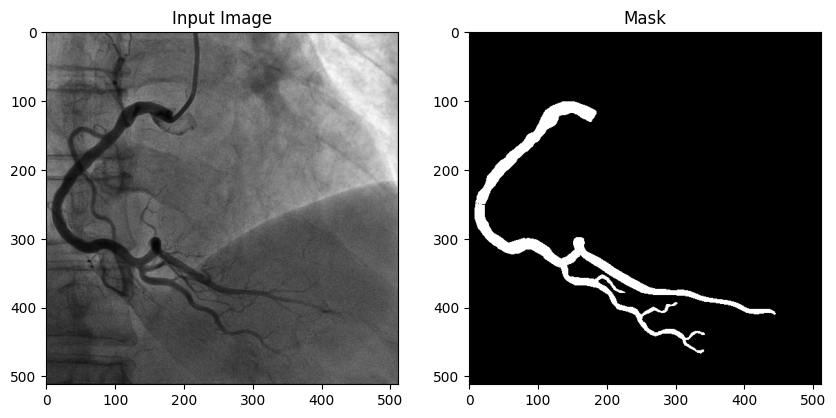

In [13]:
# Plot the input image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(batch['transformed_image'][0, 0, :, :].numpy(), cmap='gray')
plt.title('Input Image')
plt.subplot(1, 2, 2)
plt.imshow(batch['masks'][0, 0, :, :].numpy(), cmap='gray')
plt.title('Mask')
plt.show()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['optimization']['learning_rate'])
losses = []
progress_bar = tqdm(range(config['optimization']['epochs']))
for epoch in progress_bar:
    model.train()
    x, y_gt = batch['transformed_image'].to(device), batch['masks'].to(device)
    loss = model.loss(x, y_gt)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    progress_bar.set_description(f"Loss: {loss.item():.4f}")
    progress_bar.refresh()

  0%|          | 0/500 [00:00<?, ?it/s]

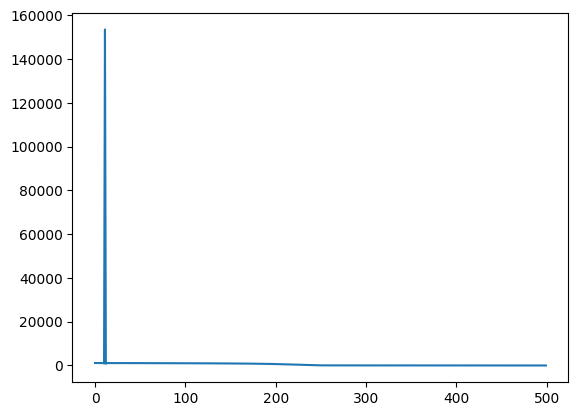

In [15]:
import matplotlib.pyplot as plt
plt.plot(losses)  

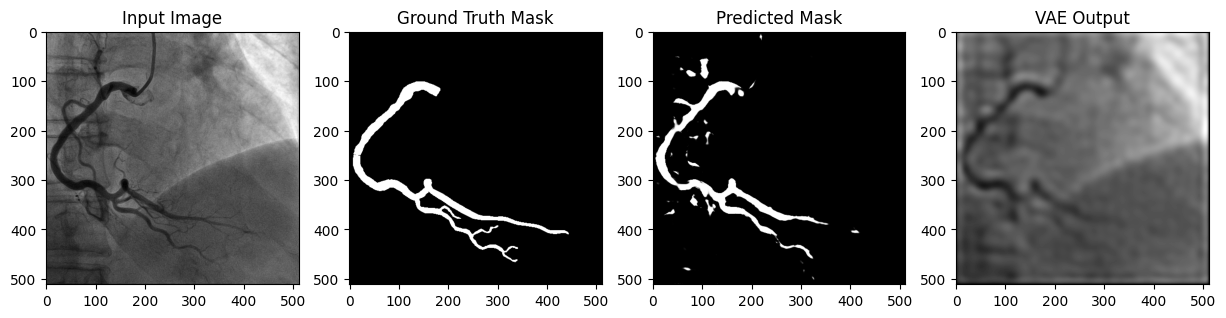

In [16]:
# Look at the output of the model
model.eval()
x, y_gt = batch['transformed_image'].to(device), batch['masks'].to(device)
decoder_output, vae_output, _, _ = model(x)

plt.subplots(figsize=(15, 5), ncols=4)
plt.subplot(1, 4, 1)
plt.imshow(x[0, 0, :, :].cpu().numpy(), cmap='gray')
plt.title('Input Image')
plt.subplot(1, 4, 2)
plt.imshow(y_gt[0, 0, :, :].cpu().numpy(), cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 4, 3)
plt.imshow(decoder_output[0, 0, :, :].detach().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')
plt.subplot(1, 4, 4)
plt.imshow(vae_output[0, 0, :, :].detach().cpu().numpy(), cmap='gray')
plt.title('VAE Output')
plt.show()